In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/henriquecosta/workspace/studies/modern-ml'

In [2]:
import catboost as cb
from sklearn.metrics import log_loss, average_precision_score
from sklearn.model_selection import train_test_split
import mlflow 
from matplotlib import pyplot as plt
import pandas as pd
import arfs.feature_selection.allrelevant as arfsgroot

/Users/henriquecosta/workspace/studies/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mlflow.set_experiment('feature_selection')

<Experiment: artifact_location='file:///Users/henriquecosta/workspace/studies/modern-ml/mlruns/688941890086194690', creation_time=1738524098359, experiment_id='688941890086194690', last_update_time=1738524098359, lifecycle_stage='active', name='feature_selection', tags={}>

In [4]:
df_train = pd.read_parquet('./case/data/processed/lending_club_case_train_dataset_v1.parquet')
df_test = pd.read_parquet('./case/data/processed/lending_club_case_test_dataset_v1.parquet')

<Axes: title={'center': 'Default rate over time'}, xlabel='issue_d'>

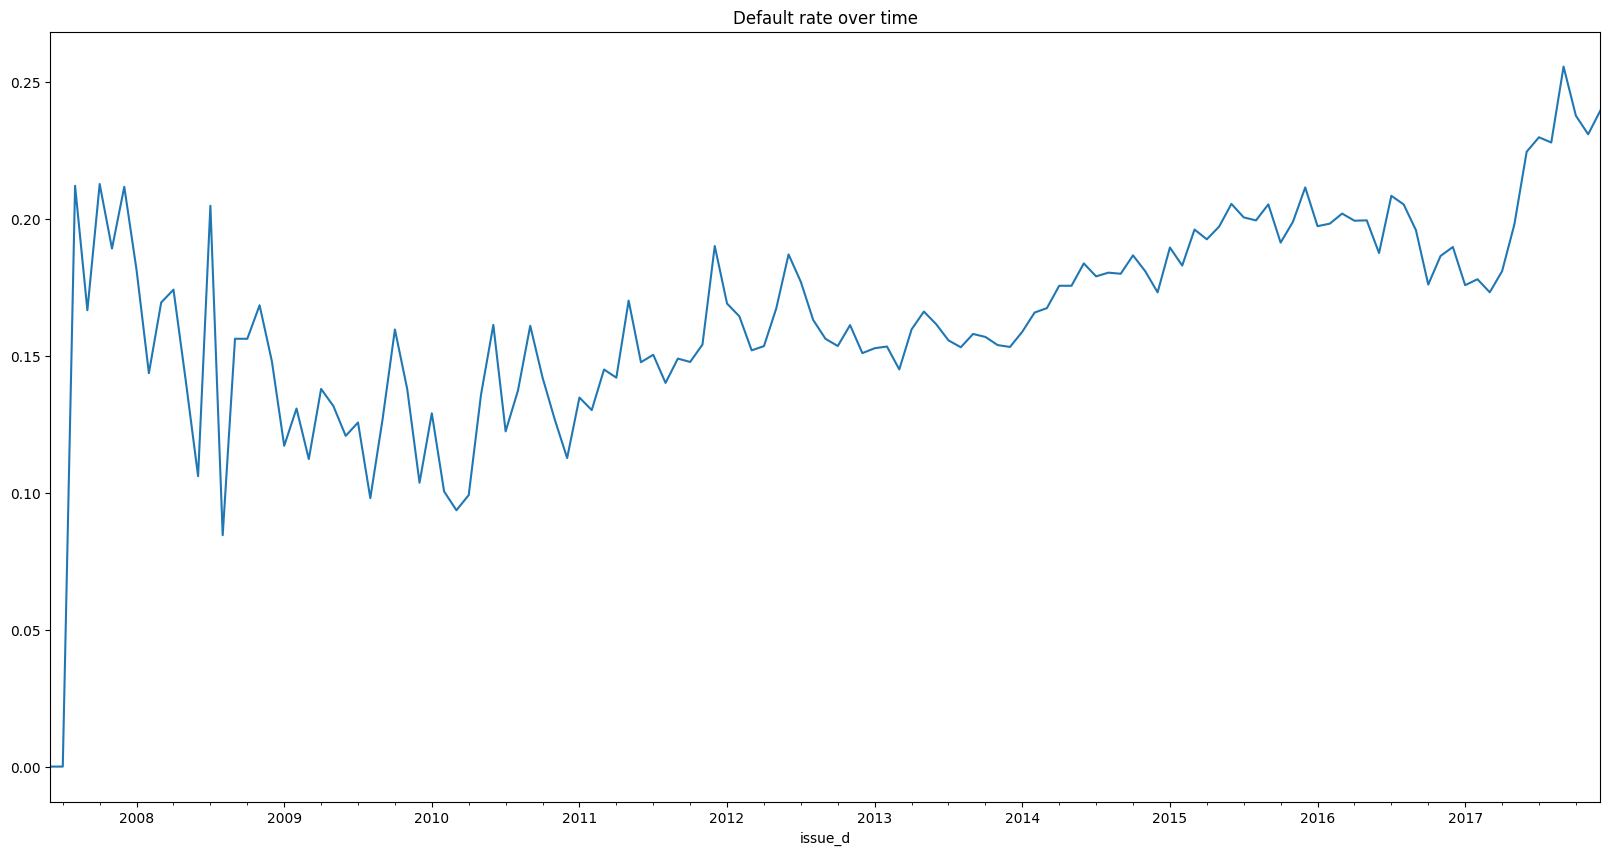

In [5]:
(
    df_train
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time')
)

In [6]:
cut_off_date = '2017-06-01'

df_valid = df_train.loc[df_train['issue_d'] >= cut_off_date]
df_train = df_train.loc[df_train['issue_d'] < cut_off_date]

<Axes: title={'center': 'Default rate over time'}, xlabel='issue_d'>

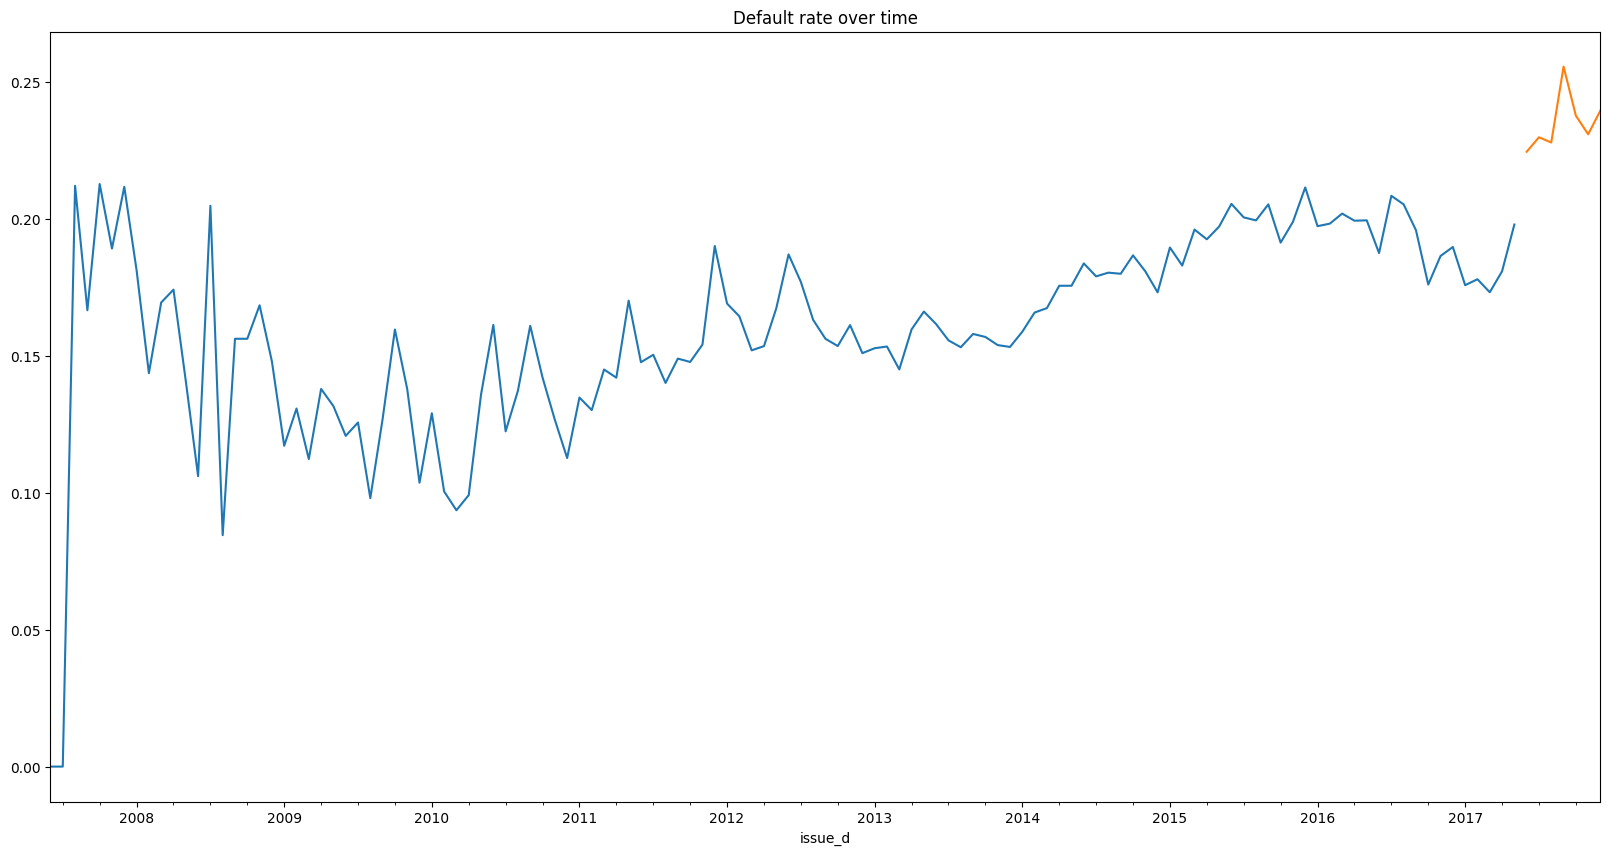

In [7]:
ax = (
    df_train
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time')
)

(
    df_valid
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time', ax=ax)
)

In [8]:
len(df_valid)

170828

# Feature Engineering   

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412818 entries, 0 to 2925491
Columns: 108 entries, id to default
dtypes: Int16(51), Int32(12), Int64(15), category(14), datetime64[ns](3), float32(12), int64(1)
memory usage: 638.9 MB


In [10]:
def datetime_features(df, cols):
    df = df.copy()
    for col in cols:
        df[f'{col}_elapse'] = df[col].astype(int) / 1e9
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month.astype('category')
        df[f'{col}_day'] = df[col].dt.day.astype('category')
        df[f'{col}_dayofweek'] = df[col].dt.dayofweek.astype('category')
        df[f'{col}_dayofyear'] = df[col].dt.dayofyear.astype('category')
        df[f'{col}_quarter'] = df[col].dt.quarter.astype('category')
        if col != 'issue_d':
            df[f'{col}_since'] = (df['issue_d'] - df[col]).dt.days
            del df[col]
    return df

In [11]:
DATE_COLS = df_train.select_dtypes(include='datetime').columns
DATE_COLS

Index(['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line'], dtype='object')

In [12]:
df_train = (
    df_train
    .pipe(datetime_features, DATE_COLS)
)

df_valid = (
    df_valid
    .pipe(datetime_features, DATE_COLS)
)

df_test = (
    df_test
    .pipe(datetime_features, DATE_COLS)
)

# Feature Selection

In [13]:
CATEGORICAL_FEATURES = df_train.select_dtypes(include='category').columns.to_list()

In [14]:
df_full = pd.concat([df_train, df_valid, df_test], ignore_index=True)
df_full[CATEGORICAL_FEATURES] = df_full[CATEGORICAL_FEATURES].astype(str).fillna('missing').astype('category')

df_train = df_full.merge(df_train[['id']], on='id', how='inner')
df_valid = df_full.merge(df_valid[['id']], on='id', how='inner')
df_test = df_full.merge(df_test[['id']], on='id', how='inner')

del df_full

In [15]:
df_train.issue_d.agg(['min', 'max'])    

min   2007-06-01
max   2017-05-01
Name: issue_d, dtype: datetime64[ns]

In [16]:
df_valid.issue_d.agg(['min', 'max'])  

min   2017-06-01
max   2017-12-01
Name: issue_d, dtype: datetime64[ns]

In [17]:
df_test.issue_d.agg(['min', 'max'])  

min   2018-01-01
max   2019-01-01
Name: issue_d, dtype: datetime64[ns]

In [18]:
# New cutoff for trianing set
cut_off_date = '2016-06-01'

In [19]:
FEATURES = [c for c in df_train.columns if c not in ['id', 'emp_title', 'default', 'issue_d']]
CATEGORICAL_FEATURES = [c for c in CATEGORICAL_FEATURES if c in FEATURES]

In [20]:
X_train = df_train.loc[df_train['issue_d'] < cut_off_date, FEATURES]
y_train = df_train.loc[df_train['issue_d'] < cut_off_date, 'default']
X_valid = df_train.loc[df_train['issue_d'] >= cut_off_date, FEATURES]
y_valid = df_train.loc[df_train['issue_d'] >= cut_off_date, 'default']

In [21]:
_, X_train, _, y_train = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [22]:
train_pool = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [23]:
mlflow.end_run()

Learning rate set to 0.131265
0:	learn: 0.6776102	test: 0.6778396	best: 0.6778396 (0)	total: 569ms	remaining: 9m 28s
10:	learn: 0.6276302	test: 0.6293861	best: 0.6293861 (10)	total: 5.27s	remaining: 7m 54s
20:	learn: 0.6200329	test: 0.6218027	best: 0.6218027 (20)	total: 9.68s	remaining: 7m 31s
30:	learn: 0.6167327	test: 0.6187218	best: 0.6187218 (30)	total: 14.1s	remaining: 7m 20s
40:	learn: 0.6150040	test: 0.6174472	best: 0.6174472 (40)	total: 18.4s	remaining: 7m 11s
50:	learn: 0.6135205	test: 0.6165506	best: 0.6165506 (50)	total: 23.3s	remaining: 7m 13s
60:	learn: 0.6123872	test: 0.6157308	best: 0.6157308 (60)	total: 28.4s	remaining: 7m 16s
70:	learn: 0.6113724	test: 0.6157914	best: 0.6152467 (69)	total: 34.8s	remaining: 7m 35s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6152467009
bestIteration = 69

Shrink model to first 70 iterations.


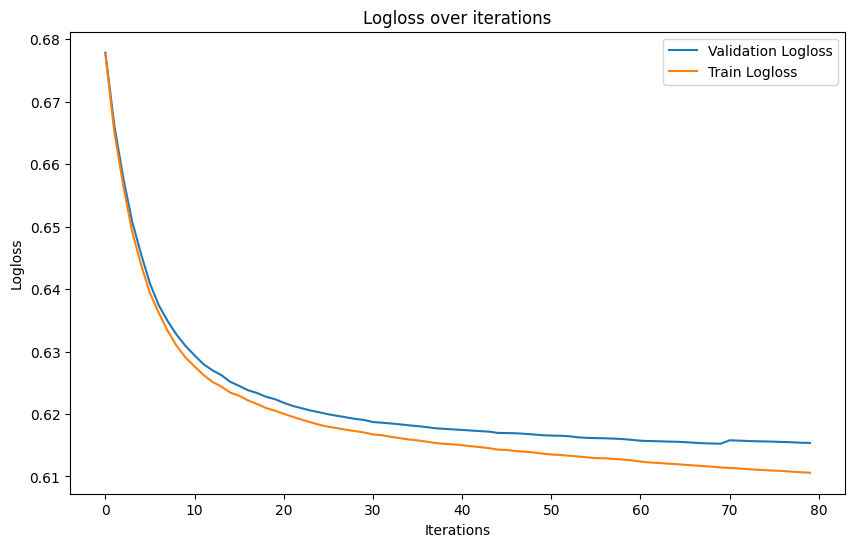

In [24]:
with mlflow.start_run(run_name='vanilla-Catboost'):
    params = dict(
        iterations=1000,
        depth=6,
        auto_class_weights='Balanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=10)
    y_pred = model.predict_proba(X_valid)[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred))

    # Plot logloss
    plt.figure(figsize=(10, 6))
    plt.plot(model.get_evals_result()['validation']['Logloss'], label='Validation Logloss')
    plt.plot(model.get_evals_result()['learn']['Logloss'], label='Train Logloss')
    plt.xlabel('Iterations')
    plt.ylabel('Logloss')
    plt.title('Logloss over iterations')
    plt.legend()

In [25]:
params = dict(
    depth=6,
    auto_class_weights='Balanced',
    eval_metric='Logloss',
)

model = cb.CatBoostClassifier(**params) 

feat_selector = arfsgroot.Leshy(
    model, n_estimators=150, verbose=10, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(CATEGORICAL_FEATURES, axis=1), y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.5
0:	learn: 0.6497353	total: 88.8ms	remaining: 13.2s
1:	learn: 0.6355177	total: 161ms	remaining: 11.9s
2:	learn: 0.6286046	total: 236ms	remaining: 11.6s
3:	learn: 0.6246016	total: 312ms	remaining: 11.4s
4:	learn: 0.6220997	total: 409ms	remaining: 11.9s
5:	learn: 0.6207130	total: 482ms	remaining: 11.6s
6:	learn: 0.6198030	total: 549ms	remaining: 11.2s
7:	learn: 0.6190405	total: 615ms	remaining: 10.9s
8:	learn: 0.6184769	total: 673ms	remaining: 10.5s
9:	learn: 0.6178852	total: 739ms	remaining: 10.3s
10:	learn: 0.6174806	total: 804ms	remaining: 10.2s
11:	learn: 0.6169496	total: 870ms	remaining: 10s
12:	learn: 0.6164799	total: 932ms	remaining: 9.82s
13:	learn: 0.6161515	total: 992ms	remaining: 9.64s
14:	learn: 0.6156988	total: 1.06s	remaining: 9.54s
15:	learn: 0.6152634	total: 1.13s	remaining: 9.43s
16:	learn: 0.6150345	total: 1.18s	remaining: 9.24s
17:	learn: 0.6148245	total: 1.23s	remaining: 9.05s
18:	learn: 0.6145554	total: 1.3s	remaining: 8.98s
19:	learn: 0.61412

Leshy iteration:  10%|█         | 1/10 [00:29<04:23, 29.29s/it]

Learning rate set to 0.5
0:	learn: 0.6497353	total: 73.9ms	remaining: 11s
1:	learn: 0.6355086	total: 139ms	remaining: 10.3s
2:	learn: 0.6285840	total: 213ms	remaining: 10.4s
3:	learn: 0.6250275	total: 279ms	remaining: 10.2s
4:	learn: 0.6224751	total: 332ms	remaining: 9.63s
5:	learn: 0.6212919	total: 384ms	remaining: 9.22s
6:	learn: 0.6202654	total: 447ms	remaining: 9.14s
7:	learn: 0.6196053	total: 502ms	remaining: 8.9s
8:	learn: 0.6186462	total: 569ms	remaining: 8.91s
9:	learn: 0.6178407	total: 647ms	remaining: 9.06s
10:	learn: 0.6173275	total: 722ms	remaining: 9.12s
11:	learn: 0.6167701	total: 797ms	remaining: 9.16s
12:	learn: 0.6165299	total: 848ms	remaining: 8.94s
13:	learn: 0.6161838	total: 911ms	remaining: 8.85s
14:	learn: 0.6158183	total: 968ms	remaining: 8.71s
15:	learn: 0.6155287	total: 1.02s	remaining: 8.59s
16:	learn: 0.6152024	total: 1.09s	remaining: 8.51s
17:	learn: 0.6149219	total: 1.15s	remaining: 8.42s
18:	learn: 0.6145095	total: 1.21s	remaining: 8.37s
19:	learn: 0.61408

Leshy iteration:  20%|██        | 2/10 [00:51<03:20, 25.02s/it]

Learning rate set to 0.5
0:	learn: 0.6493950	total: 135ms	remaining: 20.1s
1:	learn: 0.6340745	total: 223ms	remaining: 16.5s
2:	learn: 0.6281935	total: 315ms	remaining: 15.4s
3:	learn: 0.6252911	total: 387ms	remaining: 14.1s
4:	learn: 0.6230766	total: 465ms	remaining: 13.5s
5:	learn: 0.6215352	total: 554ms	remaining: 13.3s
6:	learn: 0.6203933	total: 633ms	remaining: 12.9s
7:	learn: 0.6197938	total: 698ms	remaining: 12.4s
8:	learn: 0.6191672	total: 767ms	remaining: 12s
9:	learn: 0.6187245	total: 823ms	remaining: 11.5s
10:	learn: 0.6180560	total: 895ms	remaining: 11.3s
11:	learn: 0.6174816	total: 986ms	remaining: 11.3s
12:	learn: 0.6171291	total: 1.04s	remaining: 11s
13:	learn: 0.6166628	total: 1.11s	remaining: 10.8s
14:	learn: 0.6162000	total: 1.19s	remaining: 10.7s
15:	learn: 0.6157437	total: 1.26s	remaining: 10.5s
16:	learn: 0.6155082	total: 1.32s	remaining: 10.3s
17:	learn: 0.6151582	total: 1.38s	remaining: 10.1s
18:	learn: 0.6147883	total: 1.44s	remaining: 9.91s
19:	learn: 0.6144305

Leshy iteration:  30%|███       | 3/10 [01:14<02:47, 23.97s/it]

Learning rate set to 0.5
0:	learn: 0.6484273	total: 69ms	remaining: 10.3s
1:	learn: 0.6345002	total: 131ms	remaining: 9.73s
2:	learn: 0.6273691	total: 203ms	remaining: 9.93s
3:	learn: 0.6241538	total: 271ms	remaining: 9.87s
4:	learn: 0.6224248	total: 329ms	remaining: 9.55s
5:	learn: 0.6209666	total: 390ms	remaining: 9.35s
6:	learn: 0.6197761	total: 457ms	remaining: 9.34s
7:	learn: 0.6192754	total: 508ms	remaining: 9.01s
8:	learn: 0.6187166	total: 565ms	remaining: 8.85s
9:	learn: 0.6182188	total: 619ms	remaining: 8.66s
10:	learn: 0.6177152	total: 683ms	remaining: 8.63s
11:	learn: 0.6172110	total: 738ms	remaining: 8.48s
12:	learn: 0.6168802	total: 798ms	remaining: 8.41s
13:	learn: 0.6164430	total: 863ms	remaining: 8.38s
14:	learn: 0.6161637	total: 909ms	remaining: 8.18s
15:	learn: 0.6156611	total: 962ms	remaining: 8.06s
16:	learn: 0.6152860	total: 1.02s	remaining: 7.99s
17:	learn: 0.6148720	total: 1.07s	remaining: 7.87s
18:	learn: 0.6145252	total: 1.13s	remaining: 7.76s
19:	learn: 0.6141

Leshy iteration:  40%|████      | 4/10 [01:34<02:15, 22.54s/it]

Learning rate set to 0.5
0:	learn: 0.6484273	total: 60.3ms	remaining: 8.98s
1:	learn: 0.6344713	total: 122ms	remaining: 9.06s
2:	learn: 0.6275302	total: 178ms	remaining: 8.73s
3:	learn: 0.6239754	total: 231ms	remaining: 8.44s
4:	learn: 0.6221550	total: 287ms	remaining: 8.32s
5:	learn: 0.6205612	total: 350ms	remaining: 8.41s
6:	learn: 0.6195816	total: 407ms	remaining: 8.31s
7:	learn: 0.6189524	total: 465ms	remaining: 8.25s
8:	learn: 0.6183559	total: 513ms	remaining: 8.04s
9:	learn: 0.6178212	total: 570ms	remaining: 7.99s
10:	learn: 0.6172189	total: 625ms	remaining: 7.9s
11:	learn: 0.6167216	total: 680ms	remaining: 7.82s
12:	learn: 0.6164354	total: 729ms	remaining: 7.68s
13:	learn: 0.6160790	total: 789ms	remaining: 7.67s
14:	learn: 0.6158139	total: 837ms	remaining: 7.53s
15:	learn: 0.6154823	total: 885ms	remaining: 7.42s
16:	learn: 0.6149483	total: 955ms	remaining: 7.47s
17:	learn: 0.6144524	total: 1.02s	remaining: 7.49s
18:	learn: 0.6141038	total: 1.08s	remaining: 7.42s
19:	learn: 0.613

Leshy iteration:  50%|█████     | 5/10 [01:53<01:46, 21.25s/it]

Learning rate set to 0.5
0:	learn: 0.6497353	total: 62.5ms	remaining: 9.3s
1:	learn: 0.6355267	total: 131ms	remaining: 9.67s
2:	learn: 0.6286115	total: 198ms	remaining: 9.7s
3:	learn: 0.6246099	total: 247ms	remaining: 9.03s
4:	learn: 0.6227785	total: 294ms	remaining: 8.53s
5:	learn: 0.6210253	total: 355ms	remaining: 8.51s
6:	learn: 0.6200597	total: 404ms	remaining: 8.26s
7:	learn: 0.6190595	total: 457ms	remaining: 8.12s
8:	learn: 0.6182515	total: 506ms	remaining: 7.93s
9:	learn: 0.6176430	total: 564ms	remaining: 7.9s
10:	learn: 0.6172480	total: 613ms	remaining: 7.74s
11:	learn: 0.6167575	total: 670ms	remaining: 7.7s
12:	learn: 0.6162535	total: 722ms	remaining: 7.61s
13:	learn: 0.6158260	total: 776ms	remaining: 7.54s
14:	learn: 0.6153806	total: 822ms	remaining: 7.4s
15:	learn: 0.6150926	total: 872ms	remaining: 7.3s
16:	learn: 0.6146346	total: 923ms	remaining: 7.22s
17:	learn: 0.6142799	total: 969ms	remaining: 7.11s
18:	learn: 0.6139348	total: 1.02s	remaining: 7.01s
19:	learn: 0.6135043	

Leshy iteration:  60%|██████    | 6/10 [02:11<01:20, 20.13s/it]

Learning rate set to 0.5
0:	learn: 0.6497353	total: 67.1ms	remaining: 9.99s
1:	learn: 0.6355034	total: 126ms	remaining: 9.32s
2:	learn: 0.6285780	total: 187ms	remaining: 9.15s
3:	learn: 0.6245848	total: 248ms	remaining: 9.04s
4:	learn: 0.6220889	total: 323ms	remaining: 9.38s
5:	learn: 0.6207044	total: 389ms	remaining: 9.34s
6:	learn: 0.6197920	total: 442ms	remaining: 9.04s
7:	learn: 0.6190286	total: 496ms	remaining: 8.79s
8:	learn: 0.6185079	total: 542ms	remaining: 8.5s
9:	learn: 0.6176889	total: 598ms	remaining: 8.37s
10:	learn: 0.6172903	total: 648ms	remaining: 8.19s
11:	learn: 0.6168157	total: 697ms	remaining: 8.02s
12:	learn: 0.6163062	total: 748ms	remaining: 7.88s
13:	learn: 0.6158586	total: 791ms	remaining: 7.68s
14:	learn: 0.6154130	total: 842ms	remaining: 7.58s
15:	learn: 0.6151873	total: 888ms	remaining: 7.44s
16:	learn: 0.6148595	total: 946ms	remaining: 7.4s
17:	learn: 0.6146819	total: 992ms	remaining: 7.27s
18:	learn: 0.6143829	total: 1.04s	remaining: 7.21s
19:	learn: 0.6138

Leshy iteration:  70%|███████   | 7/10 [02:29<00:58, 19.65s/it]

Learning rate set to 0.5
0:	learn: 0.6493950	total: 69ms	remaining: 10.3s
1:	learn: 0.6340745	total: 125ms	remaining: 9.24s
2:	learn: 0.6281935	total: 191ms	remaining: 9.34s
3:	learn: 0.6252911	total: 250ms	remaining: 9.12s
4:	learn: 0.6230766	total: 303ms	remaining: 8.78s
5:	learn: 0.6215352	total: 371ms	remaining: 8.89s
6:	learn: 0.6203933	total: 493ms	remaining: 10.1s
7:	learn: 0.6197972	total: 565ms	remaining: 10s
8:	learn: 0.6190965	total: 624ms	remaining: 9.78s
9:	learn: 0.6185739	total: 682ms	remaining: 9.55s
10:	learn: 0.6180824	total: 733ms	remaining: 9.26s
11:	learn: 0.6175008	total: 786ms	remaining: 9.04s
12:	learn: 0.6171991	total: 833ms	remaining: 8.78s
13:	learn: 0.6166350	total: 919ms	remaining: 8.93s
14:	learn: 0.6162324	total: 1.02s	remaining: 9.18s
15:	learn: 0.6158188	total: 1.15s	remaining: 9.61s
16:	learn: 0.6155311	total: 1.23s	remaining: 9.66s
17:	learn: 0.6152628	total: 1.3s	remaining: 9.55s
18:	learn: 0.6150952	total: 1.39s	remaining: 9.56s
19:	learn: 0.6146774

Leshy iteration:  80%|████████  | 8/10 [02:57<00:44, 22.01s/it]

Learning rate set to 0.5
0:	learn: 0.6484121	total: 66.9ms	remaining: 9.96s
1:	learn: 0.6338984	total: 118ms	remaining: 8.71s
2:	learn: 0.6282052	total: 176ms	remaining: 8.6s
3:	learn: 0.6252552	total: 230ms	remaining: 8.38s
4:	learn: 0.6228794	total: 278ms	remaining: 8.05s
5:	learn: 0.6215176	total: 333ms	remaining: 8s
6:	learn: 0.6201396	total: 386ms	remaining: 7.88s
7:	learn: 0.6191890	total: 449ms	remaining: 7.98s
8:	learn: 0.6185937	total: 498ms	remaining: 7.8s
9:	learn: 0.6180512	total: 539ms	remaining: 7.54s
10:	learn: 0.6176043	total: 586ms	remaining: 7.4s
11:	learn: 0.6169754	total: 641ms	remaining: 7.38s
12:	learn: 0.6166079	total: 698ms	remaining: 7.36s
13:	learn: 0.6162251	total: 749ms	remaining: 7.28s
14:	learn: 0.6158204	total: 798ms	remaining: 7.18s
15:	learn: 0.6153530	total: 847ms	remaining: 7.09s
16:	learn: 0.6150322	total: 903ms	remaining: 7.06s
17:	learn: 0.6145906	total: 978ms	remaining: 7.17s
18:	learn: 0.6143679	total: 1.04s	remaining: 7.17s
19:	learn: 0.6139951	

Leshy iteration:  90%|█████████ | 9/10 [03:13<00:21, 21.47s/it]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	32
Tentative: 	12
Rejected: 	53
All relevant predictors selected in 00:03:14.00



The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x18ae88a10>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x111C9E840, verbose=10)

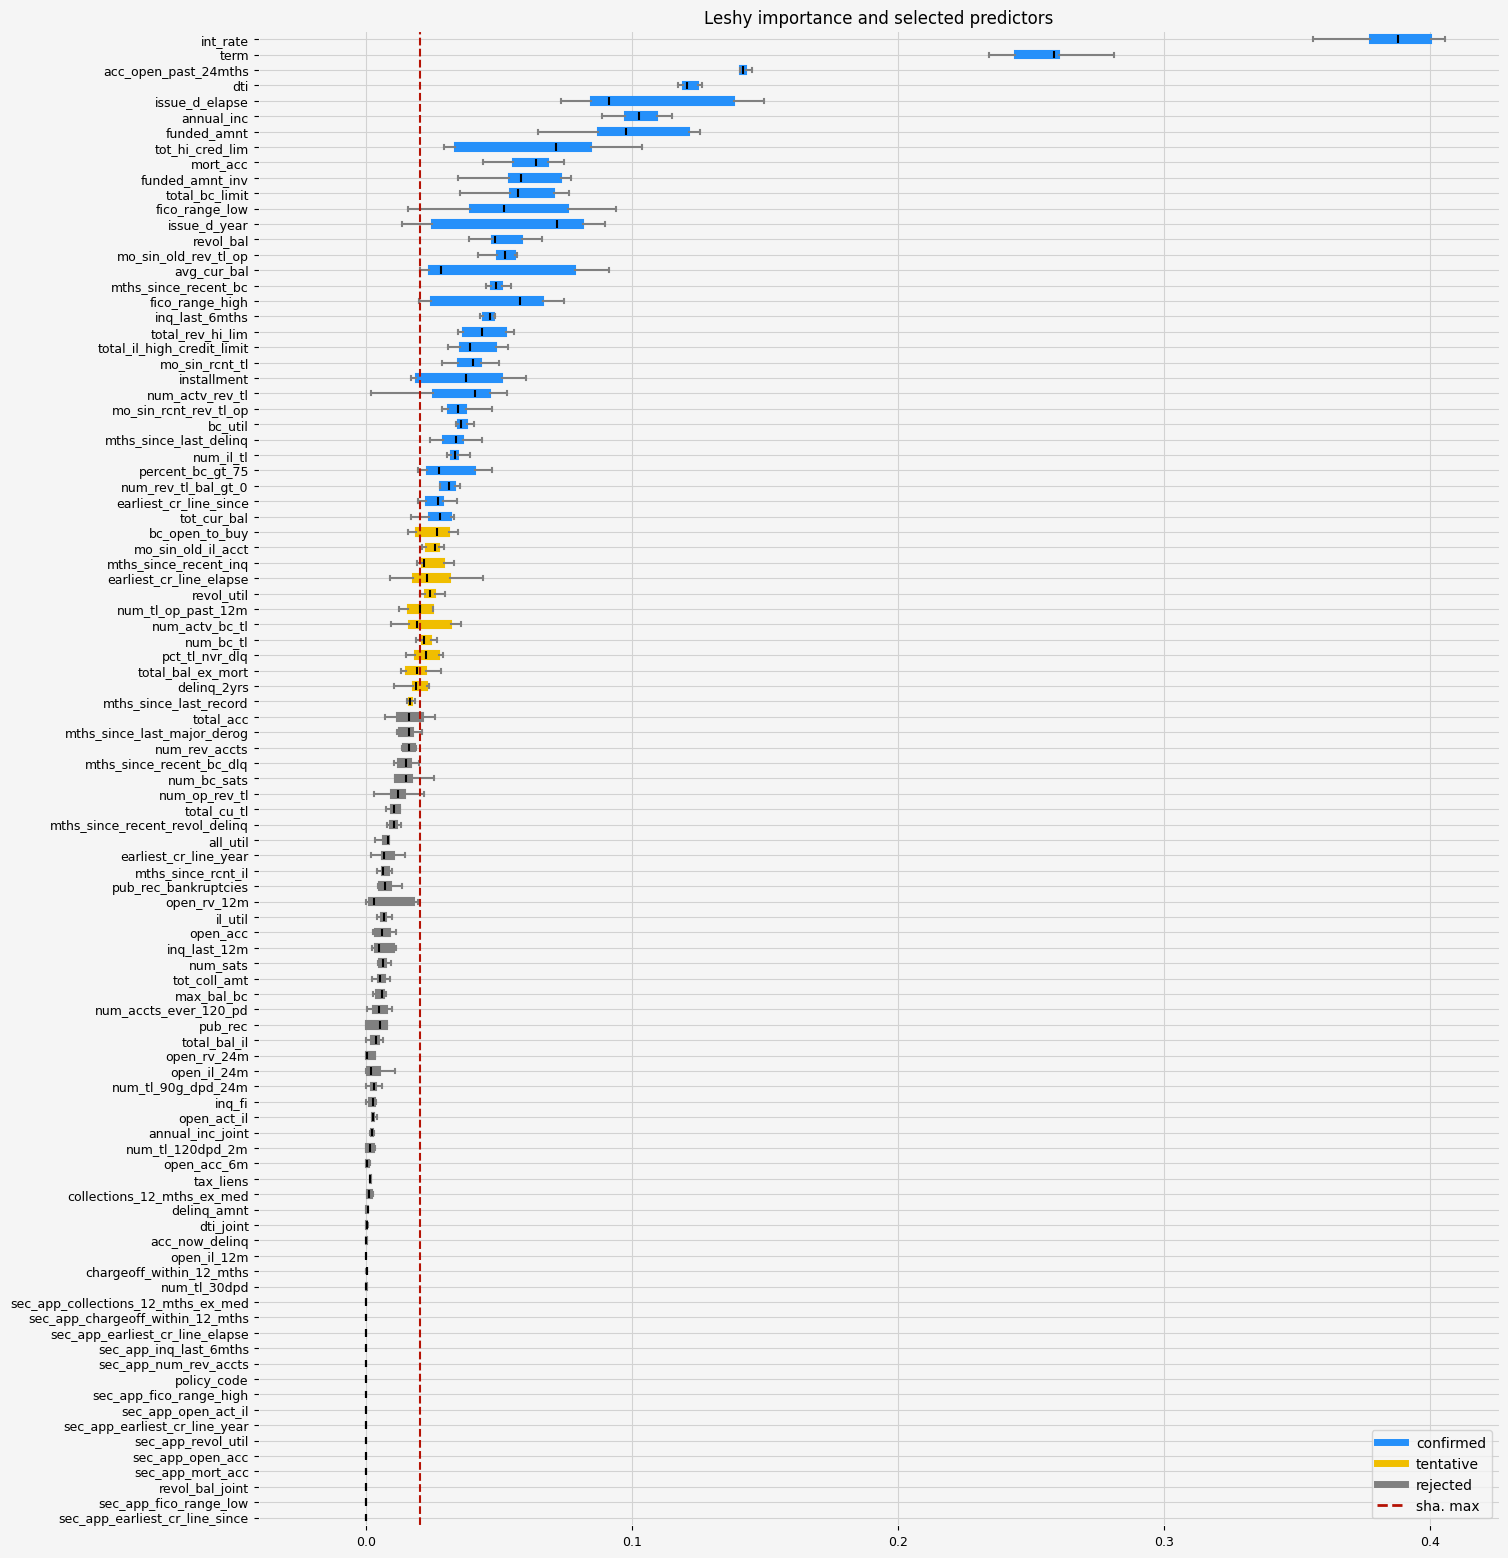

In [26]:
feat_selector.plot_importance();

In [27]:
SELECTED_FEATURES = feat_selector.selected_features_.tolist() + CATEGORICAL_FEATURES
SELECTED_FEATURES 

['funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'revol_bal',
 'revol_util',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_tl_bal_gt_0',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'issue_d_elapse',
 'earliest_cr_line_since',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status_joint',
 'issue_d_month',
 'issue_d_day',
 'issue_d_dayofweek',
 'issue_d_dayofyear',
 'issue_d_quarter',
 'earliest_cr_line_month',
 'earliest_cr_line_day',
 'earliest_cr_li

In [28]:
train_pool = cb.Pool(X_train[SELECTED_FEATURES], y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_valid[SELECTED_FEATURES], y_valid, cat_features=CATEGORICAL_FEATURES)

Learning rate set to 0.131265
0:	learn: 0.6770745	test: 0.6780202	best: 0.6780202 (0)	total: 742ms	remaining: 12m 20s
10:	learn: 0.6279032	test: 0.6301929	best: 0.6301929 (10)	total: 5.79s	remaining: 8m 40s
20:	learn: 0.6199511	test: 0.6220237	best: 0.6220237 (20)	total: 10.5s	remaining: 8m 7s
30:	learn: 0.6166049	test: 0.6188788	best: 0.6188788 (30)	total: 15.5s	remaining: 8m 4s
40:	learn: 0.6145331	test: 0.6169648	best: 0.6169648 (40)	total: 20.7s	remaining: 8m 5s
50:	learn: 0.6131742	test: 0.6160236	best: 0.6160236 (50)	total: 25.9s	remaining: 8m 2s
60:	learn: 0.6121388	test: 0.6154602	best: 0.6154602 (60)	total: 31.3s	remaining: 8m 1s
70:	learn: 0.6112821	test: 0.6150369	best: 0.6150369 (70)	total: 37.4s	remaining: 8m 9s
80:	learn: 0.6105062	test: 0.6147679	best: 0.6147679 (80)	total: 43.2s	remaining: 8m 10s
90:	learn: 0.6098010	test: 0.6144298	best: 0.6144298 (90)	total: 48.6s	remaining: 8m 5s
100:	learn: 0.6089306	test: 0.6140024	best: 0.6140024 (100)	total: 56.5s	remaining: 8m 2

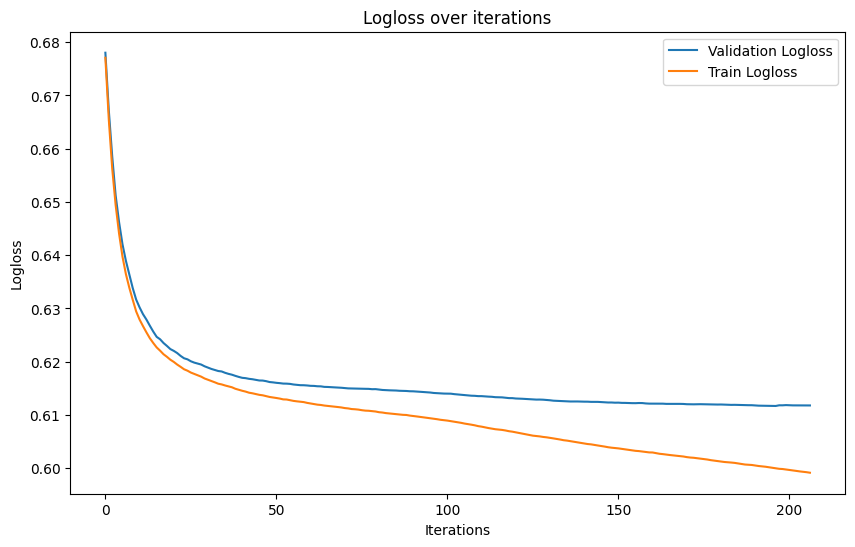

In [29]:
with mlflow.start_run(run_name='FS-Catboost'):
    params = dict(
        iterations=1000,
        depth=6,
        auto_class_weights='Balanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=10)
    y_pred = model.predict_proba(X_valid[SELECTED_FEATURES])[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred))
    with open('features.txt', 'w') as f:
        f.write('\n'.join(SELECTED_FEATURES))
    mlflow.log_artifact('features.txt')

    # Plot logloss
    plt.figure(figsize=(10, 6))
    plt.plot(model.get_evals_result()['validation']['Logloss'], label='Validation Logloss')
    plt.plot(model.get_evals_result()['learn']['Logloss'], label='Train Logloss')
    plt.xlabel('Iterations')
    plt.ylabel('Logloss')
    plt.title('Logloss over iterations')
    plt.legend()

In [30]:
df_train[['id', 'default', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_train_dataset_v2.parquet')
df_valid[['id', 'default', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_valid_dataset_v2.parquet')
df_test[['id', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_test_dataset_v2.parquet')